In [2]:
# Connect to google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change directory to the project folder
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Median-Filtering-Forensics-Based-on-Convlutional-Neural-Network')

In [4]:
import cv2
import os
import numpy as np
import random
import shutil
import glob
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from utils import *
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping

dataset_path = './data/UCID/ucid.v2'
jpeg_dataset_path = './data/UCID/JPEG70'
saved_model_path = './data/saved_models'

In [ ]:
tf.__version__

'2.13.0'

In [7]:
def createModel():
    model = Sequential()

    model.add(Input(batch_shape=(None, 64, 64, 1)))

    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', input_shape=(64, 64, 1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(5120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

# Generating Data Set (Original uncompressed images and 3x3 Median filtered images)
- For positive dataset crop the images into $64 \times 64$ image and apply $3\times3$ median filter. Then substract the image by $3\times3$ median filtered image.
- For negative dataset crop the images into $64 \times 64$ image and then substract the image by $3\times3$ median filtered image.

In [ ]:
if os.path.isdir('./data/OMF3/train') is False:
    # Creating directories for train, valid and test dataset
    os.makedirs('./data/OMF3/train/Original')
    os.makedirs('./data/OMF3/train/MF3')
    os.makedirs('./data/OMF3/valid/Original')
    os.makedirs('./data/OMF3/valid/MF3')
    os.makedirs('./data/OMF3/test/Original')
    os.makedirs('./data/OMF3/test/MF3')

    ## Positive Data
    for img in os.listdir(dataset_path):
        img_name = img.split('.')[0] + '.png'

        # reading the image in grayscale
        I = cv2.imread(os.path.join(dataset_path, img), 0)

        np.clip(I, 0, 255, out=I)
        I.astype('uint8')

        I = cv2.medianBlur(I, 3)          # MP3 filtered data
        I = cv2.medianBlur(I, 3) - I      # MFR-filter layer
        if I.shape == (512, 384):
            I = I.T

        # Cropping 6, 64x64 images from a single image
        for j in range(6):
            I_crop = crop(I, j)
            cv2.imwrite(f'./data/OMF3/MF3-{j}-{img_name}', I_crop)

    ## Negative Data
    for img in os.listdir(dataset_path):
        img_name = img.split('.')[0] + '.png'

        # reading the image in grayscale
        I = cv2.imread(os.path.join(dataset_path, img), 0)

        I = cv2.medianBlur(I, 3) - I    # MFR-filter layer
        if I.shape == (512, 384):
            I = I.T

        # Cropping 6, 64x64 images from a single image
        for j in range(6):
            I_crop = crop(I, j)
            cv2.imwrite(f'./data/OMF3/O-{j}-{img_name}', I_crop)


    # Move the images into train (50%), valid (25%) and test (25%) folders
    # with respect to their classes
    assert len(glob.glob('./data/OMF3/O*')) == 8028
    assert len(glob.glob('./data/OMF3/MF3*')) == 8028

    for c in random.sample(glob.glob('./data/OMF3/O*'), 4014):
        shutil.move(c, './data/OMF3/train/Original')

    for c in random.sample(glob.glob('./data/OMF3/MF3*'), 4014):
        shutil.move(c, './data/OMF3/train/MF3')

    for c in random.sample(glob.glob('./data/OMF3/O*'), 2007):
        shutil.move(c, './data/OMF3/valid/Original')

    for c in random.sample(glob.glob('./data/OMF3/MF3*'), 2007):
        shutil.move(c, './data/OMF3/valid/MF3')

    for c in random.sample(glob.glob('./data/OMF3/O*'), 2007):
        shutil.move(c, './data/OMF3/test/Original')

    for c in random.sample(glob.glob('./data/OMF3/MF3*'), 2007):
        shutil.move(c, './data/OMF3/test/MF3')

In [ ]:
train_path = './data/OMF3/train'
valid_path = './data/OMF3/valid'
test_path = './data/OMF3/test'

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['Original', 'MF3'], shuffle=True)
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['Original', 'MF3'], shuffle=True)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['Original', 'MF3'], shuffle=False)

Found 8028 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.


In [ ]:
OMF3_model = createModel()
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=10, restore_best_weights=True)

In [ ]:
OMF3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
OMF3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 384)       1

In [ ]:
history = OMF3_model.fit(train_batches,
                         batch_size=train_batches.samples,
                         steps_per_epoch=train_batches.samples//train_batches.batch_size,
                         validation_batch_size=valid_batches.samples,
                         validation_data=valid_batches,
                         validation_steps=valid_batches.samples//valid_batches.batch_size,
                         epochs=50,
                         verbose=1,
                         callbacks=[es])

Epoch 1/50
31/31 [==============================] - 1510s 49s/step - loss: 1.6838 - accuracy: 0.5335 - val_loss: 0.6943 - val_accuracy: 0.4997
Epoch 2/50
31/31 [==============================] - 18s 582ms/step - loss: 0.6783 - accuracy: 0.5341 - val_loss: 0.6765 - val_accuracy: 0.5005
Epoch 3/50
31/31 [==============================] - 22s 719ms/step - loss: 0.7644 - accuracy: 0.5666 - val_loss: 0.6591 - val_accuracy: 0.8539
Epoch 4/50
31/31 [==============================] - 22s 717ms/step - loss: 0.8706 - accuracy: 0.5657 - val_loss: 0.6708 - val_accuracy: 0.5026
Epoch 5/50
31/31 [==============================] - 18s 582ms/step - loss: 0.6142 - accuracy: 0.7194 - val_loss: 0.9322 - val_accuracy: 0.7102
Epoch 6/50
31/31 [==============================] - 18s 578ms/step - loss: 0.3448 - accuracy: 0.8837 - val_loss: 0.1769 - val_accuracy: 0.9435
Epoch 7/50
31/31 [==============================] - 22s 718ms/step - loss: 0.2850 - accuracy: 0.9072 - val_loss: 0.1515 - val_accuracy: 0.9510

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

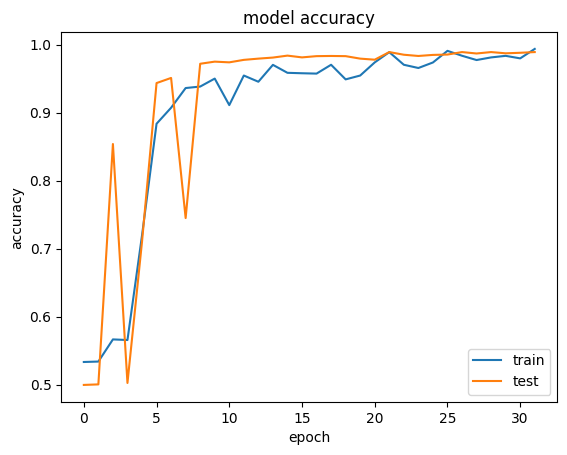

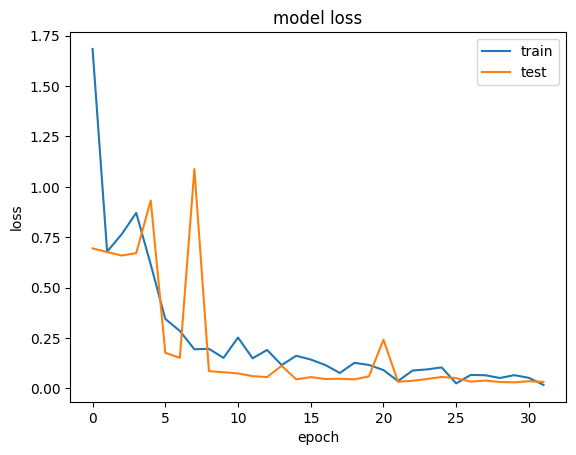

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
score, acc = OMF3_model.evaluate(test_batches, steps=test_batches.samples//test_batches.batch_size+1, verbose=0)
print(f'Test score is: {score}')
print(f'Test accuracy is: {acc}')

Test score is: 0.04864845424890518
Test accuracy is: 0.9900348782539368


In [ ]:
train_score, train_acc = OMF3_model.evaluate(train_batches, steps=train_batches.samples//train_batches.batch_size+1, verbose=0)
print(f'Train score is: {train_score}')
print(f'Train accuracy is: {train_acc}')

Train score is: 0.015033712610602379
Train accuracy is: 0.9943946003913879


In [ ]:
valid_score, valid_acc = OMF3_model.evaluate(valid_batches, steps=valid_batches.samples//valid_batches.batch_size+1, verbose=0)
print(f'Valid score is: {valid_score}')
print(f'Valid accuracy is: {valid_acc}')

Valid score is: 0.0396248996257782
Valid accuracy is: 0.9900348782539368


In [ ]:
# Saving the model
[os.makedirs(saved_model_path) if os.path.exists(saved_model_path) is False else None]
if os.path.isfile(os.path.join(saved_model_path, 'OMF3_model.h5')) is False:
    OMF3_model.save(os.path.join(saved_model_path, 'OMF3_model.h5'))

In [ ]:
# Load the model
OMF3_model = load_model(os.path.join(saved_model_path,'OMF3_model.h5'), compile=True)

Manual Prediction \\
$[1., 0.]=$ non median filtered images \\
$[0., 1.]=$  median filtered images

1/1 [==============================] - 0s 378ms/step
Positive
[[0. 1.]]


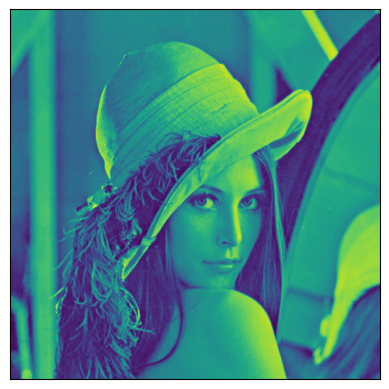

In [ ]:
# Prediction on a single image
I = cv2.imread('Lena.tiff', 0)
image = I.copy()
np.clip(I, 0, 255, out=I)
I.astype('uint8')
I = cv2.medianBlur(I, 3)          # MP3 filtered data
I = cv2.medianBlur(I, 3) - I
shape = I.shape
I = I[shape[0]//2-32:shape[0]//2+32, shape[1]//2-32:shape[1]//2+32]
I = I.reshape(1, 64, 64, 1)

plt.imshow(image)
plt.xticks([]); plt.yticks([])

prediction = np.round(OMF3_model.predict(I))
if prediction[0][0] == 0:
    print('Positive')
else:
    print('Negative')
print(prediction)

# Generating Data Set (JPEG 70 compressed images and 3x3 Median filtered of JPEG images)

Creating JPEG_70 Images

In [ ]:
if os.path.exists(jpeg_dataset_path) is False:
    os.makedirs(jpeg_dataset_path)
    for img in os.listdir(dataset_path):
        I = Image.open(os.path.join(dataset_path, img))
        img_name = img.split('.')[0] + '.jpeg'

        I.save(os.path.join(jpeg_dataset_path, img_name), 'JPEG', quality=70)

In [ ]:
if os.path.exists('./data/JPEG70-MF3/train') is False:
    os.makedirs('./data/JPEG70-MF3/train')
    os.makedirs('./data/JPEG70-MF3/valid')
    os.makedirs('./data/JPEG70-MF3/test')

    os.makedirs('./data/JPEG70-MF3/train/JPEG70')
    os.makedirs('./data/JPEG70-MF3/train/MF3')

    os.makedirs('./data/JPEG70-MF3/valid/JPEG70')
    os.makedirs('./data/JPEG70-MF3/valid/MF3')

    os.makedirs('./data/JPEG70-MF3/test/JPEG70')
    os.makedirs('./data/JPEG70-MF3/test/MF3')

    # Positive Data
    for img in os.listdir(jpeg_dataset_path):
        I = cv2.imread(os.path.join(jpeg_dataset_path, img), 0)
        np.clip(I, 0, 255, out=I)
        I.astype('uint8')

        I = cv2.medianBlur(I, 3)          # MP3 filtered data
        I = cv2.medianBlur(I, 3) - I      # MFR-filter layer
        if I.shape == (512, 384):
            I = I.T

        # Cropping 6, 64x64 images from a single image
        for j in range(6):
            I_crop = crop(I, j)
            cv2.imwrite(f'./data/JPEG70-MF3/MF3-{str(j)}{img}', I_crop)

    # Negative Data
    for img in os.listdir(jpeg_dataset_path):
        I = cv2.imread(os.path.join(jpeg_dataset_path, img), 0)
        np.clip(I, 0, 255, out=I)
        I.astype('uint8')

        I = cv2.medianBlur(I, 3) - I     # MFR-filter layer
        if I.shape == (512, 384):
            I = I.T

        # Cropping 6, 64x64 images from a single image
        for j in range(6):
            I_crop = crop(I, j)
            cv2.imwrite(f'./data/JPEG70-MF3/JPEG-{str(j)}{img}', I_crop)


    # Move data into train, valid and test directory
    assert len(glob.glob('./data/JPEG70-MF3/JPEG*')) == 8028
    assert len(glob.glob('./data/JPEG70-MF3/MF3*')) == 8028

    for c in random.sample(glob.glob('./data/JPEG70-MF3/JPEG*'), 4014):
        shutil.move(c, './data/JPEG70-MF3/train/JPEG70')

    for c in random.sample(glob.glob('./data/JPEG70-MF3/MF3*'), 4014):
        shutil.move(c, './data/JPEG70-MF3/train/MF3')

    for c in random.sample(glob.glob('./data/JPEG70-MF3/JPEG*'), 2007):
        shutil.move(c, './data/JPEG70-MF3/valid/JPEG70')

    for c in random.sample(glob.glob('./data/JPEG70-MF3/MF3*'), 2007):
        shutil.move(c, './data/JPEG70-MF3/valid/MF3')

    for c in random.sample(glob.glob('./data/JPEG70-MF3/JPEG*'), 2007):
        shutil.move(c, './data/JPEG70-MF3/test/JPEG70')

    for c in random.sample(glob.glob('./data/JPEG70-MF3/MF3*'), 2007):
        shutil.move(c, './data/JPEG70-MF3/test/MF3')

In [ ]:
train_path = './data/JPEG70-MF3/train'
valid_path = './data/JPEG70-MF3/valid'
test_path = './data/JPEG70-MF3/test'

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['JPEG70', 'MF3'], shuffle=True)
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['JPEG70', 'MF3'], shuffle=True)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['JPEG70', 'MF3'], shuffle=False)

Found 8028 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.


In [ ]:
JPEG70_MF3_model = createModel()
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=10, restore_best_weights=True)

JPEG70_MF3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
JPEG70_MF3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 384)       1

In [ ]:
history = JPEG70_MF3_model.fit(train_batches,
                               batch_size=train_batches.samples,
                               steps_per_epoch=train_batches.samples//train_batches.batch_size,
                               validation_batch_size=valid_batches.samples,
                               validation_data=valid_batches,
                               validation_steps=valid_batches.samples//valid_batches.batch_size,
                               epochs=50,
                               verbose=1,
                               callbacks=[es])

Epoch 1/50
31/31 [==============================] - 1453s 47s/step - loss: 0.8268 - accuracy: 0.5214 - val_loss: 0.6887 - val_accuracy: 0.5789
Epoch 2/50
31/31 [==============================] - 23s 736ms/step - loss: 0.6947 - accuracy: 0.5188 - val_loss: 0.6926 - val_accuracy: 0.5292
Epoch 3/50
31/31 [==============================] - 22s 726ms/step - loss: 0.7516 - accuracy: 0.5251 - val_loss: 0.6945 - val_accuracy: 0.4990
Epoch 4/50
31/31 [==============================] - 23s 748ms/step - loss: 0.7176 - accuracy: 0.5809 - val_loss: 0.4940 - val_accuracy: 0.6740
Epoch 5/50
31/31 [==============================] - 19s 602ms/step - loss: 0.8854 - accuracy: 0.6378 - val_loss: 0.6305 - val_accuracy: 0.8375
Epoch 6/50
31/31 [==============================] - 23s 757ms/step - loss: 0.5203 - accuracy: 0.7975 - val_loss: 0.2940 - val_accuracy: 0.8940
Epoch 7/50
31/31 [==============================] - 23s 733ms/step - loss: 0.3955 - accuracy: 0.8560 - val_loss: 0.4344 - val_accuracy: 0.8438

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

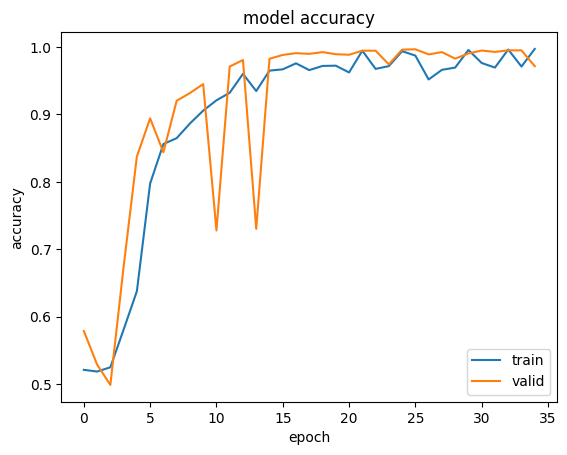

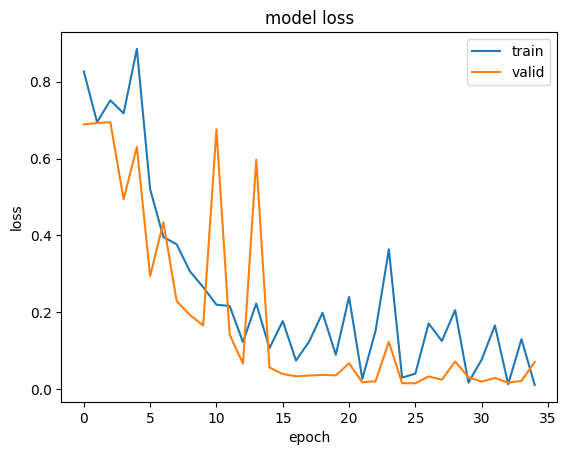

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
score, acc = JPEG70_MF3_model.evaluate(test_batches, steps=test_batches.samples//test_batches.batch_size+1, verbose=0)
print(f'Test score is: {score}')
print(f'Test accuracy is: {acc}')

Test score is: 0.02226807363331318
Test accuracy is: 0.9935226440429688


In [ ]:
train_score, train_acc = JPEG70_MF3_model.evaluate(train_batches, steps=train_batches.samples//train_batches.batch_size+1, verbose=0)
print(f'Train score is: {train_score}')
print(f'Train accuracy is: {train_acc}')

Train score is: 0.005973744206130505
Train accuracy is: 0.9983806610107422


In [ ]:
valid_score, valid_acc = JPEG70_MF3_model.evaluate(valid_batches, steps=valid_batches.samples//valid_batches.batch_size+1, verbose=0)
print(f'Valid score is: {valid_score}')
print(f'Valid accuracy is: {valid_acc}')

Valid score is: 0.016890287399291992
Valid accuracy is: 0.9955157041549683


In [ ]:
# Saving the model
[os.makedirs(saved_model_path) if os.path.exists(saved_model_path) is False else None]
if os.path.isfile(os.path.join(saved_model_path, 'JPEG70_MF3_model.h5')) is False:
    JPEG70_MF3_model.save(os.path.join(saved_model_path, 'JPEG70_MF3_model.h5'))

In [ ]:
# Loading the model
JPEG70_MF3_model = load_model(os.path.join(saved_model_path,  'JPEG70_MF3_model.h5'), compile=True)

1/1 [==============================] - 0s 178ms/step
Positive
[[0. 1.]]


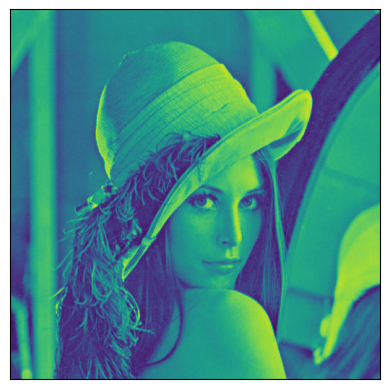

In [ ]:
# Prediction on a single image
I = cv2.imread('Lena.jpeg', 0)
image = I.copy()
np.clip(I, 0, 255, out=I)
I.astype('uint8')

I = cv2.medianBlur(I, 3)          # MP3 filtered data
I = cv2.medianBlur(I, 3) - I

shape = I.shape
I = I[shape[0]//2-32:shape[0]//2+32, shape[1]//2-32:shape[1]//2+32]
I = I.reshape(1, 64, 64, 1)

plt.imshow(image)
plt.xticks([]); plt.yticks([])

prediction = np.round(JPEG70_MF3_model.predict(I))
if prediction[0][0] == 0:
    print('Positive')
else:
    print('Negative')
print(prediction)

# Classification model between Original+JPEG70 image and MF5+MF5_JPEG70 Images

In [ ]:
# Data generation
if not os.path.exists('./data/MF5-JPEG70'):
    # Creating folders
    for dir in ['train', 'valid', 'test']:
        for c in ['class-0', 'class-1']:
            os.makedirs(f'./data/MF5-JPEG70/{dir}/{c}')

    # Copy Original and JPEG70 data from previous dataset to current working folder
    for dir in ['train', 'valid', 'test']:
        for img in os.listdir(os.path.join('./data/JPEG70-MF3', dir, 'JPEG70')):
            shutil.copy(os.path.join('./data/JPEG70-MF3', dir, 'JPEG70', img), './data/MF5-JPEG70')

        for img in os.listdir(os.path.join('./data/OMF3', dir, 'Original')):
            shutil.copy(os.path.join('./data/OMF3', dir, 'Original', img), './data/MF5-JPEG70')

    # Creating MF5 and MF3JPEG70 data
    for img in os.listdir(dataset_path):
        I = cv2.imread(os.path.join(dataset_path, img), 0)
        img_name = img.split('.')[0]

        blurred_I = cv2.medianBlur(I, 5)
        blurred_I = cv2.medianBlur(blurred_I, 5) - blurred_I    # MFR-filter layer

        if blurred_I.size == (512, 384):
            blurred_I = blurred_I.T

        # Cropping 6, 64x64 images from a single image
        for j in range(6):
            I_crop = crop(np.asarray(blurred_I), j)
            cv2.imwrite('./data/temp.png', I_crop)
            (Image.open('./data/temp.png')).save(f"./data/MF5-JPEG70/MF5-JPEG70-{j}-{img_name}.jpeg", 'JPEG' , quality=70)

            I_crop = crop(blurred_I, j)
            cv2.imwrite(f'./data/MF5-JPEG70/MF5-{str(j)}-{img_name}.png', I_crop)

    os.remove('./data/temp.png')

    assert len(glob.glob('./data/MF5-JPEG70/*jpeg')) + len(glob.glob('./data/MF5-JPEG70/*png')) == 32112

    # Move the data into respective directories
    for dir, num in {'train': 4014, 'valid': 2007, 'test': 2007}.items():
        for img in random.sample(glob.glob('./data/MF5-JPEG70/MF5-JPEG70*'), num):
            shutil.move(img, f'./data/MF5-JPEG70/{dir}/class-1')

    for dir, num in {'train': 4014, 'valid': 2007, 'test': 2007}.items():
        for img in random.sample(glob.glob('./data/MF5-JPEG70/MF5*'), num):
            shutil.move(img, f'./data/MF5-JPEG70/{dir}/class-1')


    for dir, num in {'train': 4014, 'valid': 2007, 'test': 2007}.items():
        for img in random.sample(glob.glob('./data/MF5-JPEG70/O*'), num):
            shutil.move(img, f'./data/MF5-JPEG70/{dir}/class-0')

        for img in random.sample(glob.glob('./data/MF5-JPEG70/JPEG*'), num):
            shutil.move(img, f'./data/MF5-JPEG70/{dir}/class-0')

In [ ]:
train_path = './data/MF5-JPEG70/train'
valid_path = './data/MF5-JPEG70/valid'
test_path = './data/MF5-JPEG70/test'

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['class-0', 'class-1'], shuffle=True)
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['class-0', 'class-1'], shuffle=True)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['class-0', 'class-1'], shuffle=False)

Found 16056 images belonging to 2 classes.
Found 8028 images belonging to 2 classes.
Found 8028 images belonging to 2 classes.


In [ ]:
combined_model = createModel()
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=10, restore_best_weights=True)

combined_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
combined_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 384)       1

In [ ]:
history = combined_model.fit(train_batches,
                             batch_size=train_batches.samples,
                             steps_per_epoch=train_batches.samples//train_batches.batch_size,
                             validation_batch_size=valid_batches.samples,
                             validation_data=valid_batches,
                             validation_steps=valid_batches.samples//valid_batches.batch_size,
                             epochs=50,
                             verbose=1,
                             callbacks=[es])

Epoch 1/50
62/62 [==============================] - 7058s 114s/step - loss: 0.8421 - accuracy: 0.5189 - val_loss: 0.6933 - val_accuracy: 0.5004
Epoch 2/50
62/62 [==============================] - 35s 555ms/step - loss: 0.8025 - accuracy: 0.5499 - val_loss: 8.0236 - val_accuracy: 0.5010
Epoch 3/50
62/62 [==============================] - 44s 715ms/step - loss: 0.8233 - accuracy: 0.6267 - val_loss: 0.5956 - val_accuracy: 0.8818
Epoch 4/50
62/62 [==============================] - 44s 717ms/step - loss: 0.6652 - accuracy: 0.8362 - val_loss: 0.1187 - val_accuracy: 0.9409
Epoch 5/50
62/62 [==============================] - 35s 567ms/step - loss: 0.3204 - accuracy: 0.8980 - val_loss: 0.2072 - val_accuracy: 0.9480
Epoch 6/50
62/62 [==============================] - 45s 725ms/step - loss: 0.2386 - accuracy: 0.9342 - val_loss: 0.0640 - val_accuracy: 0.9792
Epoch 7/50
62/62 [==============================] - 34s 546ms/step - loss: 0.1183 - accuracy: 0.9615 - val_loss: 0.0679 - val_accuracy: 0.975

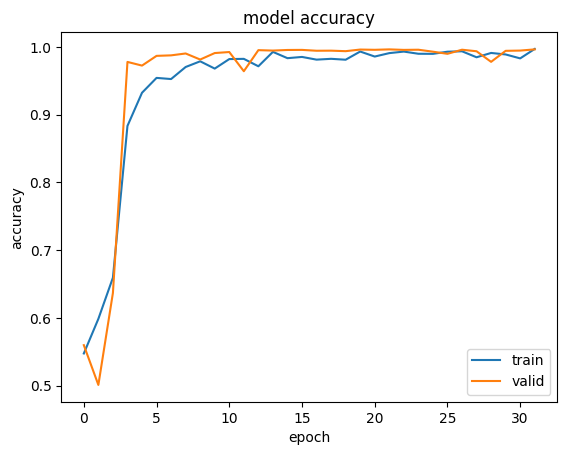

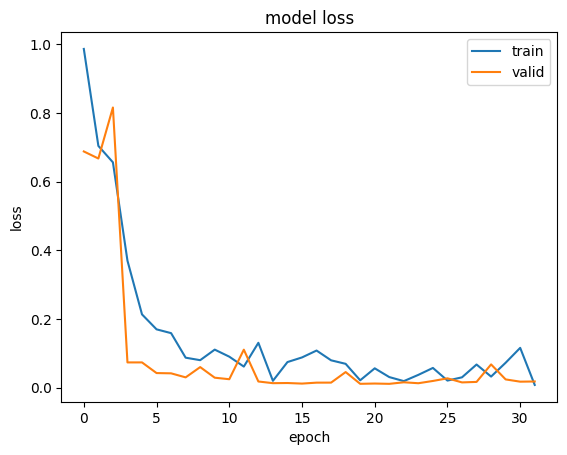

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
score, acc = combined_model.evaluate(test_batches, steps=test_batches.samples//test_batches.batch_size+1, verbose=0)
print(f'Test score is: {score}')
print(f'Test accuracy is: {acc}')

Test score is: 0.012869171798229218
Test accuracy is: 0.9946437478065491


In [ ]:
train_score, train_acc = combined_model.evaluate(train_batches, steps=train_batches.samples//train_batches.batch_size+1, verbose=0)
print(f'Train score is: {train_score}')
print(f'Train accuracy is: {train_acc}')

Train score is: 0.0072652725502848625
Train accuracy is: 0.9976955652236938


In [ ]:
valid_score, valid_acc = combined_model.evaluate(valid_batches, steps=valid_batches.samples//valid_batches.batch_size+1, verbose=0)
print(f'Valid score is: {valid_score}')
print(f'Valid accuracy is: {valid_acc}')

Valid score is: 0.012891300022602081
Valid accuracy is: 0.9955157041549683


In [ ]:
# Saving the model
[os.makedirs(saved_model_path) if os.path.exists(saved_model_path) is False else None]
if os.path.isfile(os.path.join(saved_model_path, 'combined_model.h5')) is False:
    combined_model.save(os.path.join(saved_model_path, 'combined_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Combined Model-2
- Positive data: 5x5 Median Filtered png images, 5x5 median filtered of JPEG70 images, JPEG70 of 5x5 median filtered png images
- Neagtive data: Original png images, JPEG70 images

In [ ]:
# Data generation
if not os.path.exists('./data/combined-2'):
    # Creating folders
    for dir in ['train', 'valid', 'test']:
        for c in ['class-0', 'class-1']:
            os.makedirs(f'./data/combined-2/{dir}/{c}')

    ## Negative data
    # Copy Original and JPEG70 data from previous dataset to current working folder
    for dir in ['train', 'valid', 'test']:
        for img in os.listdir(os.path.join('./data/OMF3', dir, 'Original')):
            shutil.copy(os.path.join('./data/OMF3', dir, 'Original', img), './data/combined-2')
        for img in glob.glob(os.path.join('./data/MF5-JPEG70', dir, 'class-0', '*jpeg')):
            shutil.copy(img, './data/combined-2')

    ## Creating positive data
    # Copy JPEG70-MF5 data from previous dataset to current working folder
    img_c = 0
    for dir in ['train', 'valid']:
        for img in glob.glob(os.path.join('./data/MF5-JPEG70', dir, 'class-1', 'MF5-JPEG70*')):
            shutil.copy(img, './data/combined-2')
            img_c += 1
            if img_c == 5352:
                break
    # Creating 5x5 median filtered images
    for img in random.sample(os.listdir(dataset_path), 892):
        img_name = img.split('.')[0] + '.png'

        # reading the image in grayscale
        I = cv2.imread(os.path.join(dataset_path, img), 0)

        np.clip(I, 0, 255, out=I)
        I.astype('uint8')

        I = cv2.medianBlur(I, 5)          # MP5 filtered data
        I = cv2.medianBlur(I, 5) - I      # MFR-filter layer
        if I.shape == (512, 384):
            I = I.T

        # Cropping 6, 64x64 images from a single image
        for j in range(6):
            I_crop = crop(I, j)
            cv2.imwrite(f'./data/combined-2/MF5-{j}-{img_name}', I_crop)

    # Creating JPEG70-MF5 data
    for img in random.sample(os.listdir(jpeg_dataset_path), 892):
        I = cv2.imread(os.path.join(jpeg_dataset_path, img), 0)
        np.clip(I, 0, 255, out=I)
        I.astype('uint8')

        I = cv2.medianBlur(I, 5)          # MP5 filtered data
        I = cv2.medianBlur(I, 5) - I      # MFR-filter layer
        if I.shape == (512, 384):
            I = I.T

        # Cropping 6, 64x64 images from a single image
        for j in range(6):
            I_crop = crop(I, j)
            cv2.imwrite(f'./data/combined-2/JPEG70-MF5-{j}-{img}', I_crop)

    assert len(glob.glob('./data/combined-2/*png')) == 13380
    assert len(glob.glob('./data/combined-2/*jpeg')) == 18732

    # Move the data into respective directories
    for dir, num in {'train': 2676, 'valid': 1338, 'test': 1338}.items():
        for img in random.sample(glob.glob('./data/combined-2/JPEG70-MF5*'), num):
            shutil.move(img, f'./data/combined-2/{dir}/class-1')
        for img in random.sample(glob.glob('./data/combined-2/MF5-JPEG70*'), num):
            shutil.move(img, f'./data/combined-2/{dir}/class-1')

    for dir, num in {'train': 2676, 'valid': 1338, 'test': 1338}.items():
        for img in random.sample(glob.glob('./data/combined-2/MF5*'), num):
            shutil.move(img, f'./data/combined-2/{dir}/class-1')


    for dir, num in {'train': 4014, 'valid': 2007, 'test': 2007}.items():
        for img in random.sample(glob.glob('./data/combined-2/O*'), num):
            shutil.move(img, f'./data/combined-2/{dir}/class-0')
        for img in random.sample(glob.glob('./data/combined-2/JPEG*'), num):
            shutil.move(img, f'./data/combined-2/{dir}/class-0')

In [6]:
train_path = './data/combined-2/train'
valid_path = './data/combined-2/valid'
test_path = './data/combined-2/test'

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['class-0', 'class-1'], shuffle=True)
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['class-0', 'class-1'], shuffle=True)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['class-0', 'class-1'], shuffle=False)

Found 16056 images belonging to 2 classes.
Found 8028 images belonging to 2 classes.
Found 8028 images belonging to 2 classes.


In [8]:
combined_2_model = createModel()
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=10, restore_best_weights=True)

combined_2_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
combined_2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 384)       1

In [9]:
history = combined_2_model.fit(train_batches,
                               batch_size=train_batches.samples,
                               steps_per_epoch=train_batches.samples//train_batches.batch_size,
                               validation_batch_size=valid_batches.samples,
                               validation_data=valid_batches,
                               validation_steps=valid_batches.samples//valid_batches.batch_size,
                               epochs=50,
                               verbose=1,
                               callbacks=[es])

Epoch 1/50
62/62 [==============================] - 4598s 74s/step - loss: 1.2728 - accuracy: 0.5271 - val_loss: 0.6785 - val_accuracy: 0.7839
Epoch 2/50
62/62 [==============================] - 35s 565ms/step - loss: 0.7599 - accuracy: 0.6080 - val_loss: 0.6895 - val_accuracy: 0.4994
Epoch 3/50
62/62 [==============================] - 36s 573ms/step - loss: 0.7399 - accuracy: 0.7406 - val_loss: 0.1984 - val_accuracy: 0.9113
Epoch 4/50
62/62 [==============================] - 44s 716ms/step - loss: 0.5061 - accuracy: 0.8850 - val_loss: 0.6738 - val_accuracy: 0.5558
Epoch 5/50
62/62 [==============================] - 44s 710ms/step - loss: 0.2755 - accuracy: 0.9300 - val_loss: 0.0607 - val_accuracy: 0.9807
Epoch 6/50
62/62 [==============================] - 44s 715ms/step - loss: 0.1723 - accuracy: 0.9468 - val_loss: 1.8471 - val_accuracy: 0.5600
Epoch 7/50
62/62 [==============================] - 44s 710ms/step - loss: 0.2542 - accuracy: 0.9349 - val_loss: 0.2058 - val_accuracy: 0.9425

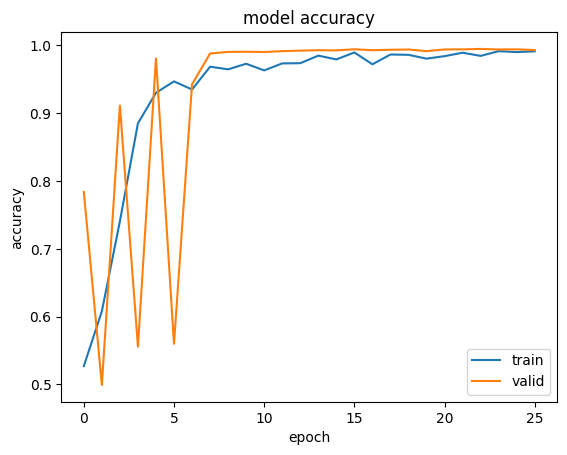

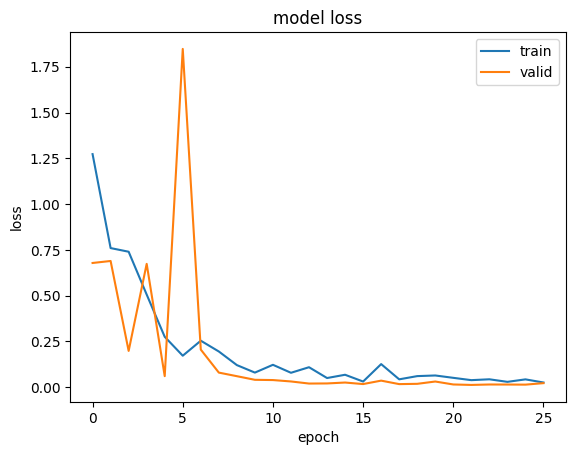

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [16]:
score, acc = combined_2_model.evaluate(test_batches, steps=test_batches.samples//test_batches.batch_size+1, verbose=1)
print(f'Test score is: {score}')
print(f'Test accuracy is: {acc}')

32/32 [==============================] - 13s 389ms/step - loss: 0.0186 - accuracy: 0.9939
Test score is: 0.01864231564104557
Test accuracy is: 0.9938963651657104


In [14]:
train_score, train_acc = combined_2_model.evaluate(train_batches, steps=train_batches.samples//train_batches.batch_size+1, verbose=1)
print(f'Train score is: {train_score}')
print(f'Train accuracy is: {train_acc}')

63/63 [==============================] - 25s 396ms/step - loss: 0.0113 - accuracy: 0.9957
Train score is: 0.011349582113325596
Train accuracy is: 0.9957025647163391


In [15]:
valid_score, valid_acc = combined_2_model.evaluate(valid_batches, steps=valid_batches.samples//valid_batches.batch_size+1, verbose=1)
print(f'Valid score is: {valid_score}')
print(f'Valid accuracy is: {valid_acc}')

32/32 [==============================] - 12s 368ms/step - loss: 0.0174 - accuracy: 0.9943
Valid score is: 0.01741185411810875
Valid accuracy is: 0.9942700266838074


In [17]:
# Saving the model
[os.makedirs(saved_model_path) if os.path.exists(saved_model_path) is False else None]
if os.path.isfile(os.path.join(saved_model_path, 'combined_2_model.h5')) is False:
    combined_2_model.save(os.path.join(saved_model_path, 'combined_2_model.h5'))